##**Install Necessary Packages**

In [ ]:
!pip install --upgrade --quiet catboost xgboost shap PDPbox alibi lime witwidget #xai

##**Import Packages**

In [ ]:
#DATA WRANGLING
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
#MODELING
from catboost import CatBoostClassifier, Pool, datasets, CatBoostRegressor
#VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
#INTERPRETATION
import scipy
import shap
from pdpbox import pdp
import lime
import lime.lime_tabular
from alibi.explainers import AnchorTabular
import witwidget
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

##**Read Data from Github Repository**

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/dtheod/Kaggle-HousePrices-AdvancedRegression/master/Real_Estate_train.csv") 
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


##**Helper Functions**

In [ ]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
        if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
    index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [ ]:
def imputation(csv, threshold):
    initial_shape_row, initial_shape_col = csv.shape

    for cols in csv.columns:
        tmp_est = np.divide(csv[str(cols)].count(), initial_shape_row)
        if tmp_est <= threshold:
            csv = csv.drop([str(cols)], axis = 1)
    
    csv = DataFrameImputer().fit_transform(csv)
    return(csv)

def remove_nas(after_imputation):
    after_imputation['ct_nas'] = after_imputation.isnull().sum(axis=1)
    mean = np.mean(after_imputation['ct_nas'], axis = 0)
    standard_deviation = np.std(after_imputation['ct_nas'], axis=0)
    after_imputation = after_imputation.loc[after_imputation['ct_nas'] < mean + 2 * standard_deviation]
    return after_imputation

def feature_engineering(features_init):
    
    #average sales per neighborhood
    def typical_aggregations(feat_ini):
        aggregation = feat_ini.groupby('Neighborhood', as_index=False).agg({"SalePrice": "mean"})
        aggregation.columns = ['Neighborhood', 'Sales_by_Neighborhood']
        feat_ini = pd.merge(feat_ini,aggregation, how='left', on= 'Neighborhood')
        feat_ini['YrSold'] = feat_ini['YrSold'].astype('category')
        aggregation1 = feat_ini.groupby('YrSold', as_index=False).agg({"SalePrice": "mean"})
        aggregation1.columns = ['YrSold', 'Sales_by_Year']
        feat_ini = pd.merge(feat_ini,aggregation1, how='left', on= 'YrSold')
        return(feat_ini)
        
    return typical_aggregations(features_init)
  
def one_hot_encoding(after_imput):
  #Change dtypes into categories
  all_data_types = list(after_imput.dtypes)
  columns = list(after_imput)
  for data_type, colum in zip(all_data_types, columns):
      if str(data_type) == 'object':
          after_imput[colum] = after_imput[colum].astype('category')
  return pd.get_dummies(after_imput)


In [ ]:
#Calling functions
after_na_removal = remove_nas(df)
after_imputation = imputation(after_na_removal, 0.8)
features_ready = feature_engineering(after_imputation)
one_hot_ready = one_hot_encoding(features_ready)
rand = 9
np.random.seed(rand)

y = one_hot_ready['SalePrice']
X = one_hot_ready.drop(['SalePrice', 'Id', 'ct_nas'], axis=1).copy()
X = X.iloc[:, :37]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)
#Initialize Model
cb_mdl = CatBoostRegressor(iterations = 1000,
                           learning_rate = 1,
                           depth = 6,
                           random_seed=rand)

#Train Model
fitted_cb_mdl_act = cb_mdl.fit(X_train, y_train, verbose=False, plot=False)

##**Predictions**

In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
def actual_values_validation(predicted, actual):
  predicted_data = pd.DataFrame(predicted)
  actual_data = pd.DataFrame(actual)
  pred_and_actual = pd.concat([predicted_data, actual_data], axis=1)
  pred_and_actual.columns = ['predicted', 'actual']
  return  pred_and_actual

predictions = fitted_cb_mdl_act.predict(X_test)

In [ ]:
mean_absolute_percentage_error(predictions, y_test)

11.506273407841846

In [ ]:
actual_values_validation(predictions, np.array(y_test))

,predicted,actual
0,149242.997396,156000
1,326614.036617,310000
2,260003.051656,261500
3,209477.215064,170000
4,239049.999001,222500
...,...,...
266,123901.971509,120000
267,260302.445135,226000
268,208868.230122,187100
269,201665.413942,136000


## **Feature Performance**

In [ ]:
X_Inter = X.iloc[:,:35]
X_train, X_test, y_train, y_test = train_test_split(X_Inter, y, test_size=0.2, random_state=rand)
#Initialize Model
cb_mdl = CatBoostRegressor(random_seed=rand)

#Train Model
fitted_cb_mdl = cb_mdl.fit(X_train, y_train, verbose=False, plot=False)

In [ ]:
features_performance_df = pd.DataFrame({'Importance':fitted_cb_mdl.get_feature_importance(),
                                        'Feature':fitted_cb_mdl.feature_names_})
features_performance_df = features_performance_df.sort_values(by = 'Importance', ascending = False)
features_performance_df = features_performance_df.head(10)

Text(0.5, 1.0, 'Feature Importance')

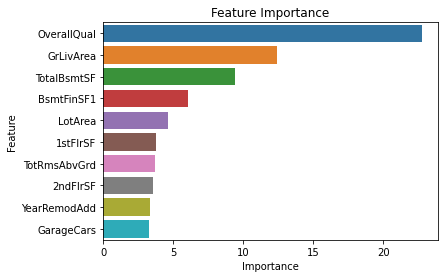

In [ ]:
sns.barplot(x = features_performance_df['Importance'], y = features_performance_df['Feature']).set_title("Feature Importance")

## **SHAP Values**

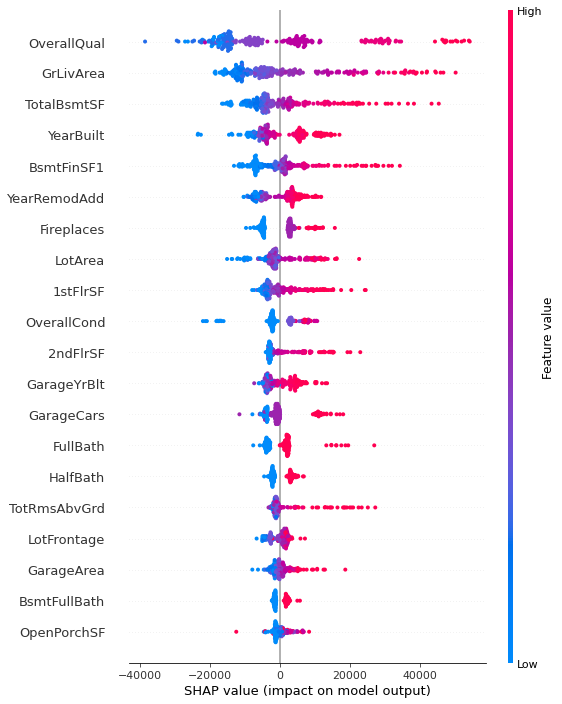

In [ ]:
shap_vals = fitted_cb_mdl.get_feature_importance(Pool(X_test, y_test),\
                                                   type="ShapValues")[:,:-1]

shap.summary_plot(shap_vals, X_test, plot_type="dot", show=False)
fig = plt.gcf()
fig.set_size_inches(8,12)
plt.show()

## **Interactions between variables**

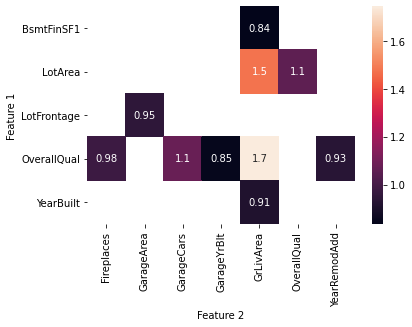

In [ ]:
col_idx_to_name = dict(zip(list(range(0, X_test.shape[1])),X_test.columns))

interactions = fitted_cb_mdl.get_feature_importance(Pool(X_test, y_test), type='Interaction', prettified=True).\
            replace(col_idx_to_name).\
            rename(columns={'First Feature Index':'Feature 1', 'Second Feature Index':'Feature 2'}).head(10)
ins = interactions.pivot("Feature 1", "Feature 2", "Interaction")
ax = sns.heatmap(ins, annot=True)

## **LIME**

Intercept 198778.36194797367
Prediction_local [177025.33891816]
Right: 164306.82684000762


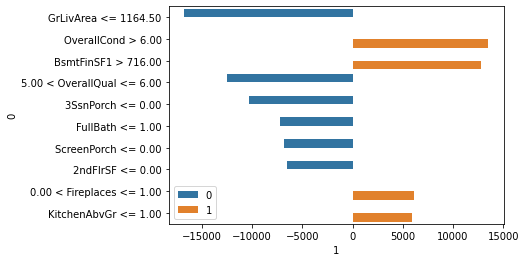

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                    feature_names=X.columns, 
                    class_names=['quality'],                             
                    verbose=True, mode='regression')

exp = explainer.explain_instance(X_test.iloc[100], 
     fitted_cb_mdl.predict, num_features=10)
local_feat_importance = pd.DataFrame(exp.as_list())

feature = local_feat_importance[0]
dir_importance = local_feat_importance[1]
colors = [1 if c >= 0 else 0 for c in dir_importance]
g = sns.barplot(
    x=dir_importance,
    y=feature,
    hue=colors, 
    palette=sns.color_palette() 
)